In [ ]:
!pip install pytorch_tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from pytorch_tabnet.utils import define_device
import pandas as pd
import numpy as np
np.random.seed(0)

import seaborn as sns
import os

from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/CSV/Training_Digital-Persona.csv')


In [ ]:
if "Filename"  in train.columns:
    train.drop(["Filename"], axis = 1, inplace = True)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/CSV/TestingDigitalPersona.csv')

In [ ]:
if "Filename"  in test.columns:
    test.drop(["Filename"], axis = 1, inplace = True)

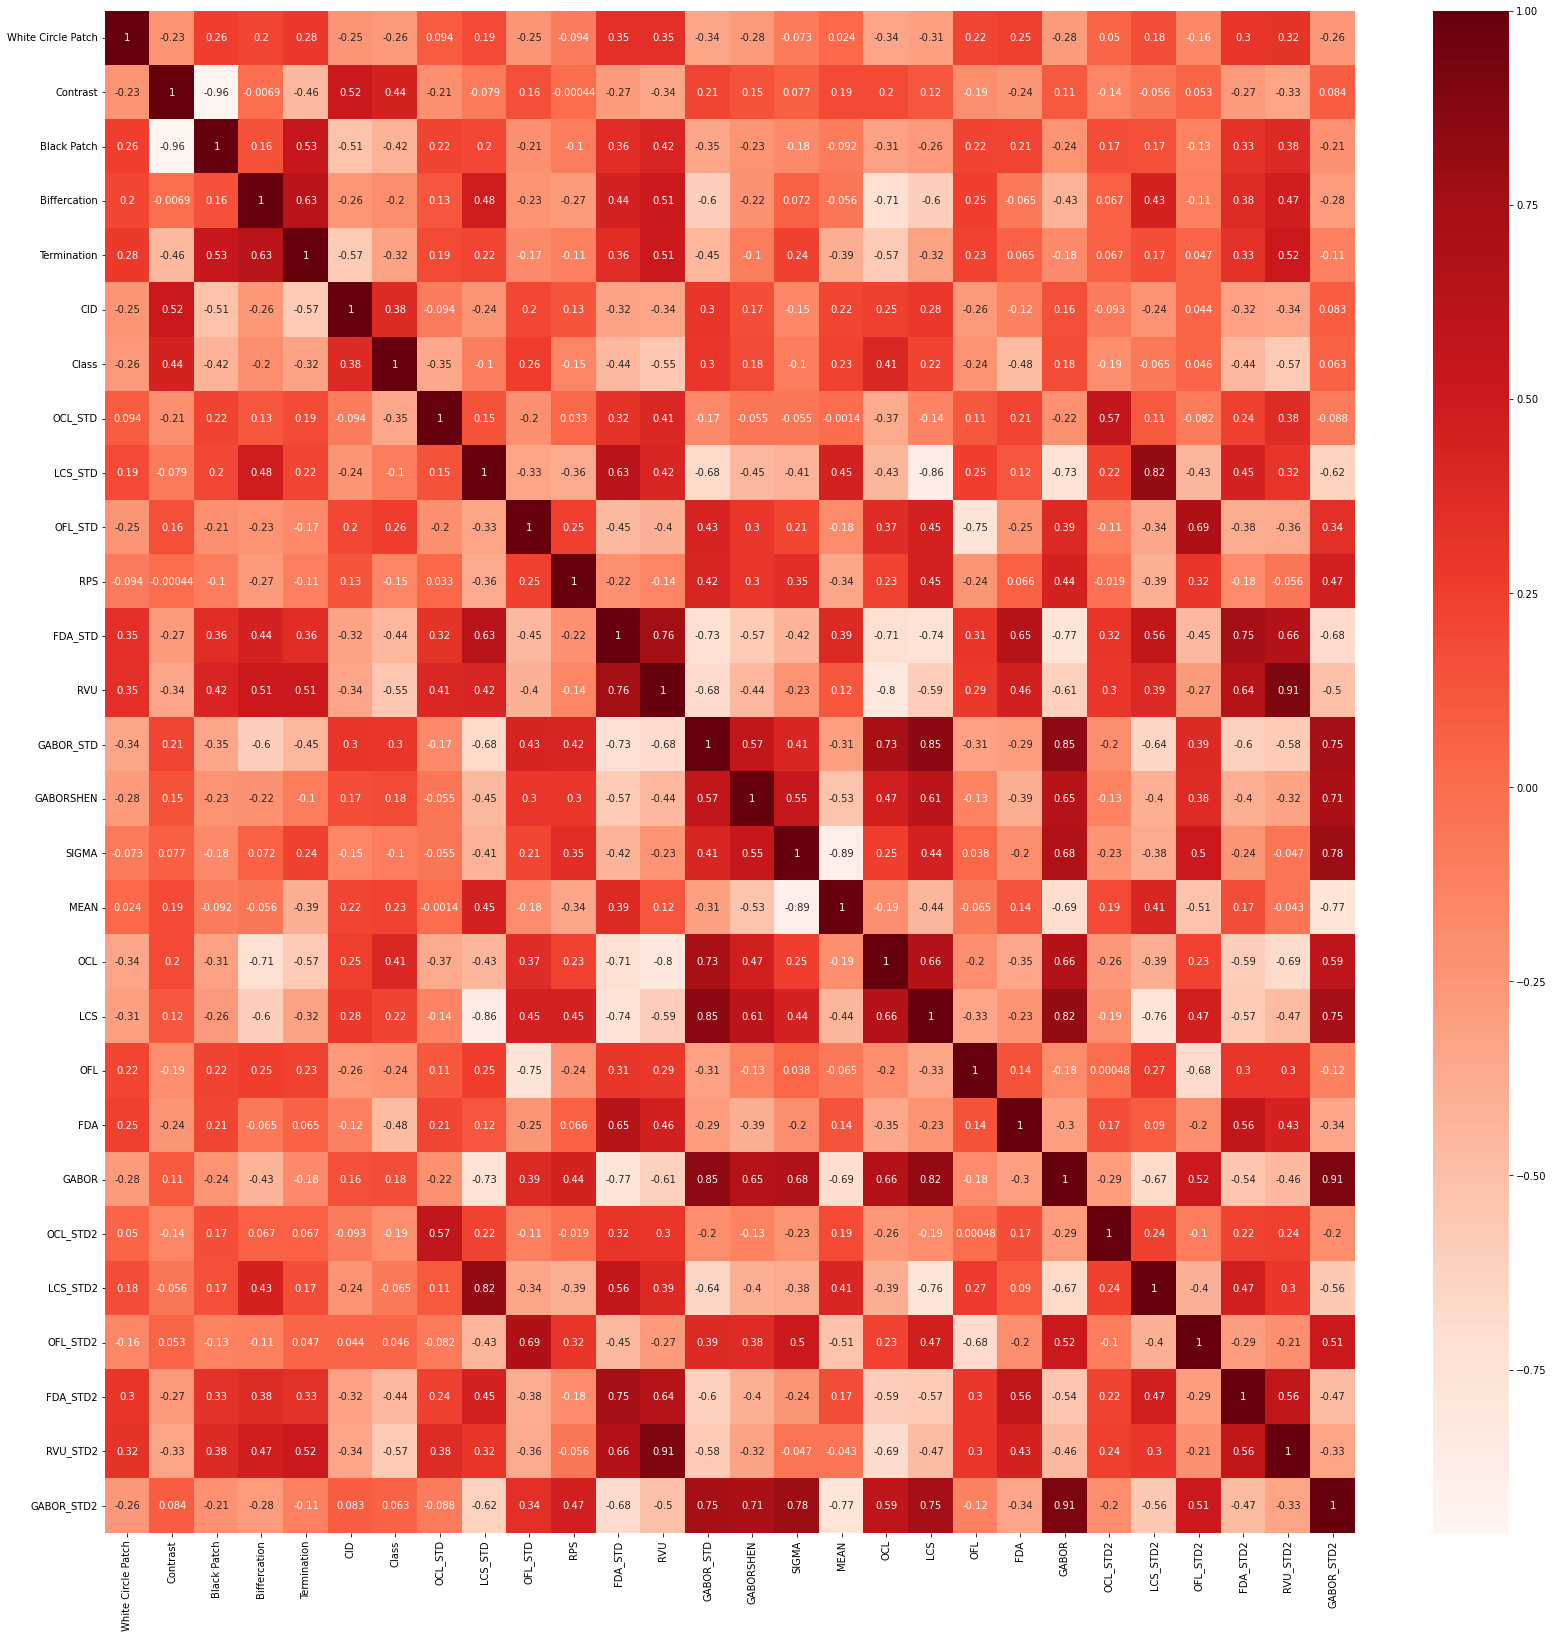

In [ ]:
plt.figure(figsize=(28,28))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
cor_target = abs(cor["Class"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.3]
relevant_features

Contrast       0.440039
Black Patch    0.422241
Termination    0.318273
CID            0.383183
Class          1.000000
OCL_STD        0.352887
FDA_STD        0.442349
RVU            0.548243
OCL            0.406305
FDA            0.477093
FDA_STD2       0.442347
RVU_STD2       0.568689
Name: Class, dtype: float64

In [ ]:
#68%, 57%
#train = train[['White Circle Patch','Contrast','Black Patch','Termination','CID','Class','OCL_STD','OFL_STD','FDA_STD','RVU','GABOR_STD','MEAN','OCL','LCS','OFL','FDA','FDA_STD2','RVU_STD2']].copy() #>=0.2, 79%,62%
#train = train[['Contrast','Black Patch','Termination','CID','Class','OCL_STD','FDA_STD','RVU','OCL','FDA','FDA_STD2','RVU_STD2']].copy() #>=0.3,90%,80%
#train = train[['Contrast','Black Patch','Class','FDA_STD','RVU','OCL','FDA','FDA_STD2','RVU_STD2']].copy() #>=0.4, 88%, 84%

In [ ]:
#test = test[['White Circle Patch','Contrast','Black Patch','Termination','CID','Class','OCL_STD','OFL_STD','FDA_STD','RVU','GABOR_STD','MEAN','OCL','LCS','OFL','FDA','FDA_STD2','RVU_STD2']].copy() #>=0.2
#test = test[['Contrast','Black Patch','Termination','CID','Class','OCL_STD','FDA_STD','RVU','OCL','FDA','FDA_STD2','RVU_STD2']].copy() #>=0.3
#test = test[['Contrast','Black Patch','Class','FDA_STD','RVU','OCL','FDA','FDA_STD2','RVU_STD2']].copy() #>=0.4

In [ ]:
target = 'Class'
if "Set"  in train.columns:
    train.drop(["Set"], axis = 1)
train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))
#train["Set"] = "train"    
train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index

In [ ]:
if "Set" in test.columns:
  test.drop(['Set'], axis = 1)
test["Set"] = "test"
test_indices = test[test.Set=="test"].index

In [ ]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Class 2
Set 2


In [ ]:
train.head()

,Contrast,Black Patch,Termination,CID,Class,OCL_STD,FDA_STD,RVU,OCL,FDA,FDA_STD2,RVU_STD2,Set
0,0.192565,0.965358,223,107.718476,1,0.106709,0.176037,0.353598,0.710952,0.487488,0.095556,0.143455,0
1,0.184950,0.967039,144,113.864787,1,0.094668,0.154466,0.331051,0.777803,0.502754,0.092978,0.107935,0
2,0.187642,0.966452,228,105.423684,1,0.111087,0.183331,0.584087,0.716943,0.484818,0.120344,0.268805,0
3,0.177059,0.969040,197,122.923574,1,0.096435,0.186131,0.417190,0.742284,0.448238,0.156784,0.182722,0
4,0.185612,0.966522,249,85.873036,1,0.098914,0.171876,0.375148,0.790276,0.462497,0.112946,0.144860,0


In [ ]:
nunique = test.nunique()
types = test.dtypes
for col in test.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)

    else:
        test.fillna(test.loc[test_indices, col].mean(), inplace=True)

Class 2
Set 1


In [ ]:
train.loc[train[target]==0, target] = "classZero"
train.loc[train[target]==1, target] = "classOne"
test.loc[test[target]==0, target] = "classZero"
test.loc[test[target]==1, target] = "classOne"

In [ ]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]
X_test = test[features].values[test_indices]
y_test = test[target].values[test_indices]


In [ ]:
X_train[0]

array([1.92564745e-01, 9.65358153e-01, 2.23000000e+02, 1.07718476e+02,
       1.06709268e-01, 1.76037291e-01, 3.53598044e-01, 7.10952231e-01,
       4.87488476e-01, 9.55558720e-02, 1.43454731e-01])

In [ ]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [ ]:
class ClassificationSMOTE():
    """
    Apply SMOTE for classification tasks.
    This will average a percentage p of the elements in the batch with other elements.
    The target will stay unchanged and keep the value of the most important row in the mix.
    """
    def __init__(self, device_name="auto", p=0.8, alpha=0.5, beta=0.5, seed=0):
        ""
        self.seed = seed
        self._set_seed()
        self.device = define_device(device_name)
        self.alpha = alpha
        self.beta = beta
        self.p = p
        if (p < 0.) or (p > 1.0):
            raise ValueError("Value of p should be between 0. and 1.")

    def _set_seed(self):
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        return

    def __call__(self, X, y):
        batch_size = X.shape[0]
        random_values = torch.rand(batch_size, device=self.device)
        idx_to_change = random_values < self.p

        # ensure that first element to switch has probability > 0.5
        np_betas = np.random.beta(self.alpha, self.beta, batch_size) / 2 + 0.5
        random_betas = torch.from_numpy(np_betas).to(self.device).float()
        index_permute = torch.randperm(batch_size, device=self.device)

        X[idx_to_change] = random_betas[idx_to_change, None] * X[idx_to_change]
        X[idx_to_change] += (1 - random_betas[idx_to_change, None]) * X[index_permute][idx_to_change].view(X[idx_to_change].size())  # noqa

        return X, y

In [ ]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [ ]:
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug,#aug, None
    )
    save_history.append(clf.history["valid_auc"])

epoch 0  | loss: 0.88063 | train_auc: 0.42221 | valid_auc: 0.38313 |  0:00:00s
epoch 1  | loss: 0.60965 | train_auc: 0.59376 | valid_auc: 0.57708 |  0:00:00s
epoch 2  | loss: 0.51928 | train_auc: 0.60755 | valid_auc: 0.60131 |  0:00:00s
epoch 3  | loss: 0.46404 | train_auc: 0.54406 | valid_auc: 0.53353 |  0:00:00s
epoch 4  | loss: 0.41937 | train_auc: 0.46221 | valid_auc: 0.4356  |  0:00:00s
epoch 5  | loss: 0.39257 | train_auc: 0.37428 | valid_auc: 0.36649 |  0:00:00s
epoch 6  | loss: 0.37551 | train_auc: 0.37903 | valid_auc: 0.3677  |  0:00:00s
epoch 7  | loss: 0.36782 | train_auc: 0.42473 | valid_auc: 0.38989 |  0:00:00s
epoch 8  | loss: 0.36748 | train_auc: 0.43807 | valid_auc: 0.40994 |  0:00:01s
epoch 9  | loss: 0.35076 | train_auc: 0.46676 | valid_auc: 0.44941 |  0:00:01s
epoch 10 | loss: 0.35402 | train_auc: 0.5293  | valid_auc: 0.52718 |  0:00:01s
epoch 11 | loss: 0.3174  | train_auc: 0.60697 | valid_auc: 0.59689 |  0:00:01s
epoch 12 | loss: 0.328   | train_auc: 0.64669 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.88063 | train_auc: 0.42221 | valid_auc: 0.38313 |  0:00:00s
epoch 1  | loss: 0.60965 | train_auc: 0.59376 | valid_auc: 0.57708 |  0:00:00s
epoch 2  | loss: 0.51928 | train_auc: 0.60755 | valid_auc: 0.60131 |  0:00:00s
epoch 3  | loss: 0.46404 | train_auc: 0.54406 | valid_auc: 0.53353 |  0:00:00s
epoch 4  | loss: 0.41937 | train_auc: 0.46221 | valid_auc: 0.4356  |  0:00:00s
epoch 5  | loss: 0.39257 | train_auc: 0.37428 | valid_auc: 0.36649 |  0:00:00s
epoch 6  | loss: 0.37551 | train_auc: 0.37903 | valid_auc: 0.3677  |  0:00:00s
epoch 7  | loss: 0.36782 | train_auc: 0.42473 | valid_auc: 0.38989 |  0:00:00s
epoch 8  | loss: 0.36748 | train_auc: 0.43807 | valid_auc: 0.40994 |  0:00:01s
epoch 9  | loss: 0.35076 | train_auc: 0.46676 | valid_auc: 0.44941 |  0:00:01s
epoch 10 | loss: 0.35402 | train_auc: 0.5293  | valid_auc: 0.52718 |  0:00:01s
epoch 11 | loss: 0.3174  | train_auc: 0.60697 | valid_auc: 0.59689 |  0:00:01s
epoch 12 | loss: 0.328   | train_auc: 0.64669 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


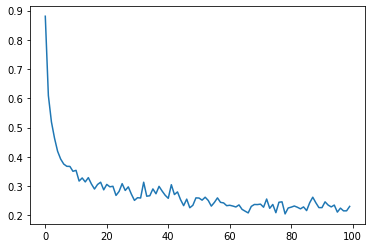

In [ ]:
plt.plot(clf.history['loss'])

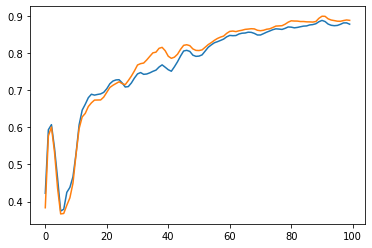

In [ ]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

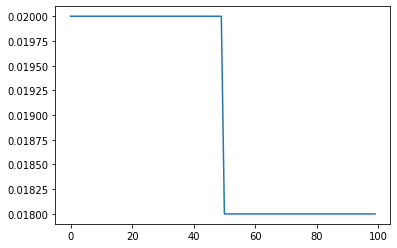

In [ ]:
plt.plot(clf.history['lr'])

In [ ]:
features

['Contrast',
 'Black Patch',
 'Termination',
 'CID',
 'OCL_STD',
 'FDA_STD',
 'RVU',
 'OCL',
 'FDA',
 'FDA_STD2',
 'RVU_STD2']

In [ ]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_auc}")

BEST VALID SCORE : 0.9003044140030441
FINAL TEST SCORE : 0.8032119805272772


In [ ]:
clf.predict(X_test)

array(['classZero', 'classZero', 'classZero', ..., 'classOne', 'classOne',
       'classOne'], dtype='<U9')

In [ ]:
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [ ]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE  : {loaded_test_auc}")

FINAL TEST SCORE  : 0.8032119805272772


In [ ]:
assert(test_auc == loaded_test_auc)

In [ ]:
loaded_clf.predict(X_test)

array(['classZero', 'classZero', 'classZero', ..., 'classOne', 'classOne',
       'classOne'], dtype='<U9')

In [ ]:
clf.feature_importances_

array([0.10498844, 0.02169721, 0.02242467, 0.18699525, 0.09546463,
       0.08940582, 0.13466593, 0.01312418, 0.1522908 , 0.06301812,
       0.11592495])

In [ ]:
explain_matrix, masks = clf.explain(X_test)

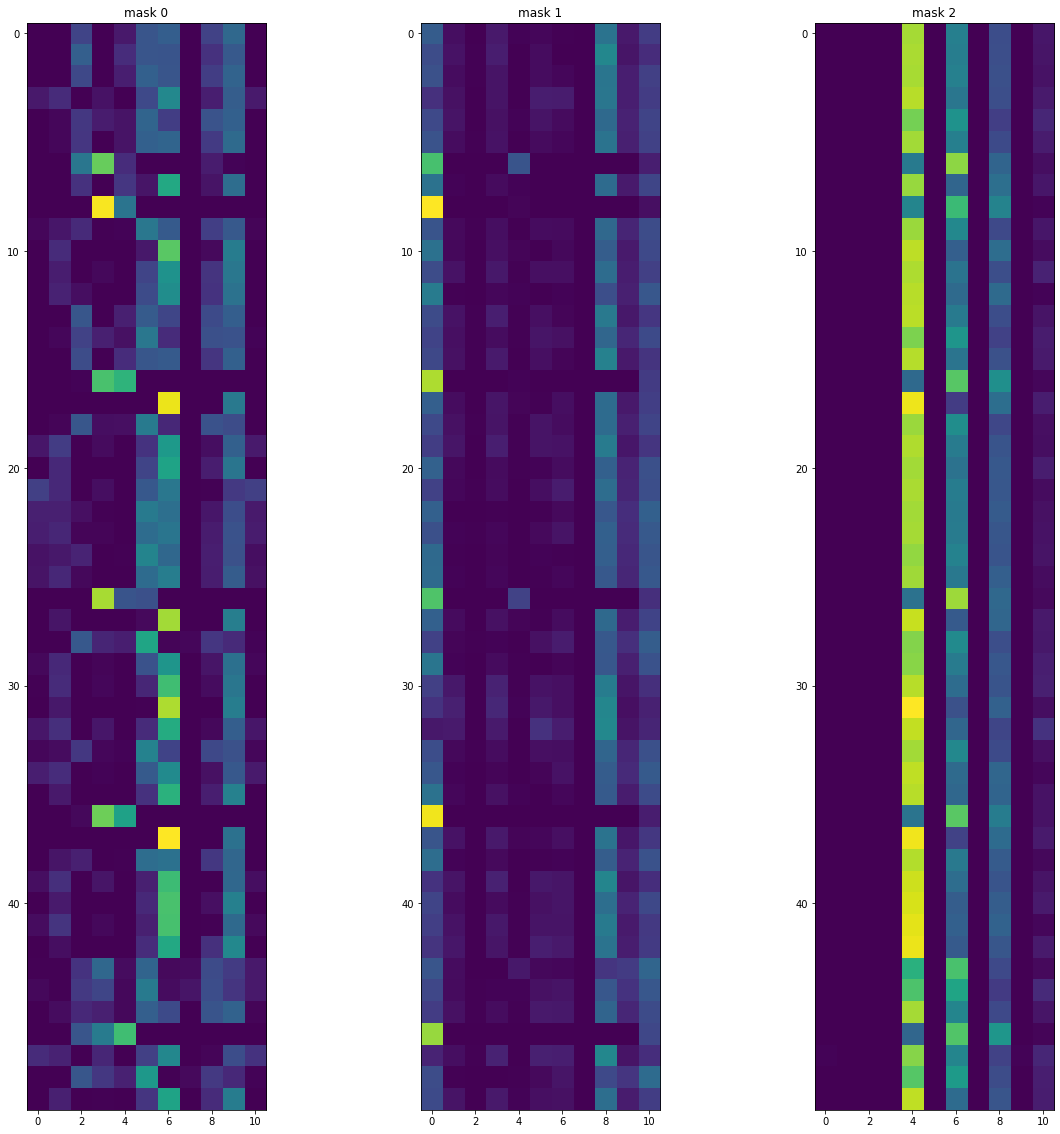

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")